In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import *
import numpy as np
#import peakutils

# Data Munging

In [2]:
#bring in the summary table 
#format the date time inorder to merge with data files
summary_df = pd.read_csv("Data/3MTestingLog.csv")
summary_df = summary_df.drop(['Table Name'], axis=1)
summary_df["Install Date Time"] = pd.to_datetime(summary_df['Date'] + ' ' + summary_df['Install Time'], format="%m/%d/%y %H:%M")
summary_df["Removal Date Time"] = pd.to_datetime(summary_df['Date'] + ' ' + summary_df['Removal Time'], format="%m/%d/%y %H:%M")

#fix the dates for when the sample was removed the following day after installation.
for i in range(len(summary_df['Date'])):
    if summary_df['Removal Date Time'][i] < summary_df['Install Date Time'][i]:
        summary_df['Removal Date Time'][i] = summary_df['Removal Date Time'][i] + timedelta(days=1)

summary_df

/Users/abby/miniconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,Date,Filter ID,Install Time,Removal Time,Indoor Temp,Outdoor Temp,Outdoor RH,Pre 20x20x1,Post 20x20x1,Pre 14x24x1,Post 14x24x1,DAQ File,Install Date Time,Removal Date Time
0,11/20/19,FG-1,13:47,16:12,72,95,50,NaN,NaN,NaN,NaN,Data-20191120134426,2019-11-20 13:47:00,2019-11-20 16:12:00
1,11/20/19,FG-2,16:16,6:13,72,95,50,NaN,NaN,NaN,NaN,Data-20191120134426,2019-11-20 16:16:00,2019-11-21 06:13:00
2,11/21/19,MERV 8-1,8:02,10:18,72,95,50,NaN,NaN,NaN,NaN,"Data-20191121080221.dld.0000,1",2019-11-21 08:02:00,2019-11-21 10:18:00
3,11/21/19,MERV 8-2,10:18,12:38,72,95,50,NaN,NaN,NaN,NaN,"Data-20191121080221.dld.0000,1",2019-11-21 10:18:00,2019-11-21 12:38:00
4,11/21/19,1900-1,12:38,14:46,72,95,50,NaN,NaN,NaN,NaN,"Data-20191121080221.dld.0000,1",2019-11-21 12:38:00,2019-11-21 14:46:00
5,11/21/19,1900-2,14:46,16:58,72,95,50,NaN,NaN,NaN,NaN,"Data-20191121080221.dld.0000,1",2019-11-21 14:46:00,2019-11-21 16:58:00
6,11/21/19,MERV 8-4,16:58,5:30,72,95,50,7.1 oz.,7.1 oz.,7.5 oz.,7.5 oz.,"Data-20191121080221.dld.0000,1",2019-11-21 16:58:00,2019-11-22 05:30:00
7,11/22/19,MERV 8-5,7:51,10:04,72,95,50,7.2 oz.,7.25 oz.,7.55 oz.,7.55 oz.,Data-20191122074415,2019-11-22 07:51:00,2019-11-22 10:04:00
8,11/22/19,1900-4,10:04,13:00,72,95,50,8.55 oz.,8.55 oz.,8 oz.,7.55 oz.,Data-20191122074415,2019-11-22 10:04:00,2019-11-22 13:00:00
9,11/22/19,1900-5,13:00,15:32,72,95,50,8.6 oz.,8.6 oz.,8.05 oz.,8.05 oz.,Data-20191122074415,2019-11-22 13:00:00,2019-11-22 15:32:00


In [3]:
summary_df.dtypes

Date                         object
Filter ID                    object
Install Time                 object
Removal Time                 object
Indoor Temp                   int64
Outdoor Temp                  int64
Outdoor RH                    int64
Pre 20x20x1                  object
Post 20x20x1                 object
Pre 14x24x1                  object
Post 14x24x1                 object
DAQ File                     object
Install Date Time    datetime64[ns]
Removal Date Time    datetime64[ns]
dtype: object

In [4]:
#Bring in the testing data 
#Had to seperate the files because some of them had different headers for the filter pressure drop
datafiles1 = ["Data/Data-20191120134426.csv", "Data/Data-20191121080221_0.csv", "Data/Data-20191121080221_1.csv"]

datafiles2 = ["Data/Data-20191122074415.csv", "Data/Data-20191125071926_0.csv", "Data/Data-20191125071926_1.csv", 
             "Data/Data-20191126061705_0.csv", "Data/Data-20191126061705_1.csv", "Data/Data-20191127053638.csv"]

usecols1 = ['Date', 'Time', "Volts", 'Volts.1', 'Amps', 'Amps.1', 'Volts.2', 'Volts.3', 'Amps.2', 'Amps.3', '0']

usecols2 = ['Date', 'Time', "Volts", 'Volts.1', 'Amps', 'Amps.1', 'Volts.2', 'Volts.3', 'Amps.2', 'Amps.3', 'In. H2']

In [5]:
#pullin the first file as a dataframe, pull the desired columns and drop the first row since there are two header rows
AllData_df = pd.DataFrame()

for file1 in datafiles1: 
    Data1_df = pd.read_csv(file1, skiprows=1, usecols=usecols1) 
    
    NonZeroData1_df = Data1_df.loc[(Data1_df['Volts']!=0)]

    AllData_df = AllData_df.append(NonZeroData1_df, ignore_index=True)
    
#remove all of the rows with zeros
#AllData_df = Data1_df.loc[(Data1_df['Volts']!=0)]

#rename the filter pressure drop column to match the rest of the files
AllData_df = AllData_df.rename(columns={'0': 'In. H2'})

AllData_df.shape

/Users/abby/miniconda3/envs/PythonData/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(136366, 11)

In [6]:
AllData_df.dtypes

Date        object
Time        object
Volts      float64
Volts.1    float64
Amps       float64
Amps.1     float64
Volts.2    float64
Volts.3    float64
Amps.2     float64
Amps.3     float64
In. H2     float64
dtype: object

In [7]:
#pull in all of the other data files and create one large file while removing all zero values
for file in datafiles2:
    Data2_df = pd.read_csv(file, skiprows=1, usecols=usecols2)

    NonZeroData2_df = Data2_df.loc[(Data2_df['Volts']!=0)]
        
    AllData_df = AllData_df.append(NonZeroData2_df, ignore_index=True)
    

AllData_df = AllData_df.rename(columns={'In. H2': 'Filter Pressure Drop (in/H2O)'})
    
AllData_df['Date and Time'] = pd.to_datetime(AllData_df['Date'] + ' ' + AllData_df['Time'], format="%Y/%m/%d %H:%M:%S")

AllData_df.shape

(357325, 12)

In [8]:
#AllData_df['Date and Time'] = pd.to_datetime(AllData_df['Date'] + ' ' + AllData_df['Time'], format="%Y/%m/%d %H:%M:%S")
#AllData_df['Date and Time'] = pd.to_datetime(AllData_df['Date'] + ' ' + AllData_df['Time'])

ZeroData_df = AllData_df.loc[AllData_df['Volts'] == 0]

ZeroData_df.shape

(0, 12)

In [9]:
#calculating Watts column as Volts+Volts.1 * Amps+Amps.1

CalculatedColumns_df = AllData_df.copy()
CalculatedColumns_df['Whole Home Power (kW)'] = ((CalculatedColumns_df['Volts']+CalculatedColumns_df['Volts.1']) * (CalculatedColumns_df['Amps']+CalculatedColumns_df['Amps.1']))/1000
CalculatedColumns_df['Compressor Power (kW)'] = ((CalculatedColumns_df['Volts.2']+CalculatedColumns_df['Volts.3']) * CalculatedColumns_df['Amps.2'])/1000
CalculatedColumns_df['Blower Fan Power (kW)'] = (CalculatedColumns_df['Amps.3'])*120/1000
CalculatedColumns_df['Compressor and Fan Power (kW)'] = CalculatedColumns_df['Compressor Power (kW)'] + CalculatedColumns_df['Blower Fan Power (kW)']
CalculatedColumns_df

,Date,Time,Volts,Volts.1,Amps,Amps.1,Volts.2,Volts.3,Amps.2,Amps.3,Filter Pressure Drop (in/H2O),Date and Time,Whole Home Power (kW),Compressor Power (kW),Blower Fan Power (kW),Compressor and Fan Power (kW)
0,2019/11/20,13:44:26,121.9,121.7,3.8,4.35,122.0,121.9,0.01,0.10,0.0,2019-11-20 13:44:26,1.985340,0.002439,0.0120,0.014439
1,2019/11/20,13:44:27,121.9,121.7,3.8,4.35,122.0,121.9,0.01,0.10,0.0,2019-11-20 13:44:27,1.985340,0.002439,0.0120,0.014439
2,2019/11/20,13:44:28,121.9,121.7,3.8,4.35,122.0,121.9,0.01,0.10,0.0,2019-11-20 13:44:28,1.985340,0.002439,0.0120,0.014439
3,2019/11/20,13:44:29,121.9,121.8,3.8,4.35,122.0,121.9,0.01,0.10,0.0,2019-11-20 13:44:29,1.986155,0.002439,0.0120,0.014439
4,2019/11/20,13:44:30,121.9,121.7,3.8,4.35,122.0,121.9,0.01,0.10,0.0,2019-11-20 13:44:30,1.985340,0.002439,0.0120,0.014439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357320,2019/11/27,12:50:12,121.8,121.7,13.1,12.28,121.5,121.4,10.20,1.74,0.2,2019-11-27 12:50:12,6.180030,2.477580,0.2088,2.686380
357321,2019/11/27,12:50:13,121.9,121.8,13.1,12.31,121.6,121.4,10.22,1.75,0.2,2019-11-27 12:50:13,6.192417,2.483460,0.2100,2.693460
357322,2019/11/27,12:50:14,121.9,121.8,13.2,12.32,121.6,121.4,10.23,1.74,0.2,2019-11-27 12:50:14,6.219224,2.485890,0.2088,2.694690
357323,2019/11/27,12:50:15,121.9,121.8,13.2,12.33,121.6,121.4,10.25,1.74,0.2,2019-11-27 12:50:15,6.221661,2.490750,0.2088,2.699550


In [10]:
#create new columns in AllData_df by using conditional (mask) and data from summary_df
#with using the combined column date and time

for i in range(len(summary_df['Filter ID'])):
    mask = (CalculatedColumns_df['Date and Time'] >= summary_df['Install Date Time'][i]) & (CalculatedColumns_df['Date and Time'] <= summary_df['Removal Date Time'][i])

    #based on the summary table, what was the filter ID during this time fame
    CalculatedColumns_df.loc[mask, 'Filter ID'] = summary_df['Filter ID'][i]
    
    #based on the summary table was the outside of the home during heating or cooling season during this time fame
    CalculatedColumns_df.loc[mask, 'Outdoor Temp'] = summary_df['Outdoor Temp'][i]
    
    #based on the summary table is the filter dirty or clean during this time fame
    if (summary_df['Filter ID'][i]=='MERV 8-4') | (summary_df['Filter ID'][i]=='MERV 8-5') | (summary_df['Filter ID'][i]=='1900-4') | (summary_df['Filter ID'][i]=='1900-5'):
        CalculatedColumns_df.loc[mask, 'Clean/Dirty'] = 'Dirty'
    else:
        CalculatedColumns_df.loc[mask, 'Clean/Dirty'] = 'Clean'
        
    #added a rolling count of seconds the filter was tested for during this time fame
    CalculatedColumns_df.loc[mask, 'Cumulative Time in Test (sec)'] = CalculatedColumns_df.loc[mask, 'Filter ID'].rolling(len(CalculatedColumns_df.loc[mask, 'Filter ID'])).count()

#remove the na's. This will be the time between the tests
FilteredData_df = CalculatedColumns_df.dropna()
FilteredData_df

,Date,Time,Volts,Volts.1,Amps,Amps.1,Volts.2,Volts.3,Amps.2,Amps.3,Filter Pressure Drop (in/H2O),Date and Time,Whole Home Power (kW),Compressor Power (kW),Blower Fan Power (kW),Compressor and Fan Power (kW),Filter ID,Outdoor Temp,Clean/Dirty,Cumulative Time in Test (sec)
154,2019/11/20,13:47:00,121.7,121.6,3.8,4.35,121.8,121.7,0.01,0.10,0.0,2019-11-20 13:47:00,1.982895,0.002435,0.0120,0.014435,FG-1,95.0,Clean,1.0
155,2019/11/20,13:47:01,121.7,121.5,3.8,4.35,121.8,121.7,0.00,0.10,0.0,2019-11-20 13:47:01,1.982080,0.000000,0.0120,0.012000,FG-1,95.0,Clean,2.0
156,2019/11/20,13:47:02,121.6,121.5,3.8,4.35,121.8,121.7,0.01,0.10,0.0,2019-11-20 13:47:02,1.981265,0.002435,0.0120,0.014435,FG-1,95.0,Clean,3.0
157,2019/11/20,13:47:03,121.6,121.5,3.8,4.35,121.7,121.6,0.00,0.10,0.0,2019-11-20 13:47:03,1.981265,0.000000,0.0120,0.012000,FG-1,95.0,Clean,4.0
158,2019/11/20,13:47:04,121.6,121.5,3.8,4.35,121.8,121.7,0.00,0.10,0.0,2019-11-20 13:47:04,1.981265,0.000000,0.0120,0.012000,FG-1,95.0,Clean,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357304,2019/11/27,12:49:56,121.9,121.8,12.5,11.65,121.6,121.4,9.59,1.74,0.2,2019-11-27 12:49:56,5.885355,2.330370,0.2088,2.539170,1900-5,40.0,Dirty,14217.0
357305,2019/11/27,12:49:57,121.9,121.8,12.5,11.71,121.6,121.4,9.65,1.74,0.2,2019-11-27 12:49:57,5.899977,2.344950,0.2088,2.553750,1900-5,40.0,Dirty,14218.0
357306,2019/11/27,12:49:58,121.9,121.8,12.6,11.77,121.6,121.4,9.70,1.74,0.2,2019-11-27 12:49:58,5.938969,2.357100,0.2088,2.565900,1900-5,40.0,Dirty,14219.0
357307,2019/11/27,12:49:59,121.9,121.8,12.6,11.81,121.6,121.4,9.75,1.74,0.2,2019-11-27 12:49:59,5.948717,2.369250,0.2088,2.578050,1900-5,40.0,Dirty,14220.0


In [46]:
second_cut_off = 7200

FilterID_CleanDirty_Combined_df = FilteredData_df.copy()
FilterID_CleanDirty_Combined_df['Filter ID'] = FilterID_CleanDirty_Combined_df['Filter ID'] + str(' ') + FilterID_CleanDirty_Combined_df['Clean/Dirty']
FilterID_CleanDirty_Combined_df = FilterID_CleanDirty_Combined_df.drop(columns=['Clean/Dirty', 'Volts', 'Volts.1', 'Volts.2', 'Volts.3', 'Amps', 'Amps.1', 'Amps.2', 'Amps.3'])
FilterID_CleanDirty_Combined_df
Grouped_FilterID_CleanDirty = FilterID_CleanDirty_Combined_df[FilterID_CleanDirty_Combined_df['Cumulative Time in Test (sec)'] <= second_cut_off].groupby(['Date and Time', 'Filter ID'])

Grouped_FilterID_CleanDirty.sum()

FilterID_CleanDirty_df = pd.DataFrame(Grouped_FilterID_CleanDirty.sum())

FilterID_CleanDirty_df.to_excel("Data/Power and PD over Time.xlsx", index=True, header=True)

FilterID_CleanDirty_df

,,Filter Pressure Drop (in/H2O),Whole Home Power (kW),Compressor Power (kW),Blower Fan Power (kW),Compressor and Fan Power (kW),Outdoor Temp,Cumulative Time in Test (sec)
Date and Time,Filter ID,,,,,,,
2019-11-20 13:47:00,FG-1 Clean,0.0,1.982895,0.002435,0.012,0.014435,95.0,1.0
2019-11-20 13:47:01,FG-1 Clean,0.0,1.982080,0.000000,0.012,0.012000,95.0,2.0
2019-11-20 13:47:02,FG-1 Clean,0.0,1.981265,0.002435,0.012,0.014435,95.0,3.0
2019-11-20 13:47:03,FG-1 Clean,0.0,1.981265,0.000000,0.012,0.012000,95.0,4.0
2019-11-20 13:47:04,FG-1 Clean,0.0,1.981265,0.000000,0.012,0.012000,95.0,5.0
...,...,...,...,...,...,...,...,...
2019-11-27 10:52:55,1900-5 Dirty,0.2,1.378377,0.031590,0.210,0.241590,40.0,7196.0
2019-11-27 10:52:56,1900-5 Dirty,0.2,1.378377,0.031590,0.210,0.241590,40.0,7197.0
2019-11-27 10:52:57,1900-5 Dirty,0.2,1.378377,0.031590,0.210,0.241590,40.0,7198.0


# Ploting Time Series Data

In [12]:

# Grouped = FilteredData_df.drop(columns=['Volts', 'Volts.1', 'Volts.2', 'Volts.3', 'Amps', 'Amps.1', 'Amps.2', 'Amps.3'])
# Grouped = FilteredData_df[FilteredData_df['Cumulative Time in Test (sec)']<=second_cut_off].groupby(['Outdoor Temp', 'Clean/Dirty', 'Filter ID'])


/Users/abby/miniconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


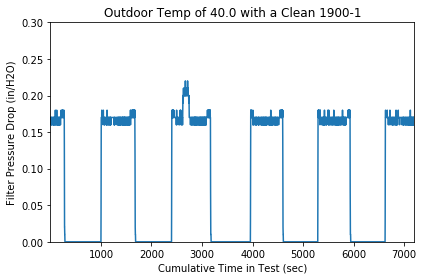

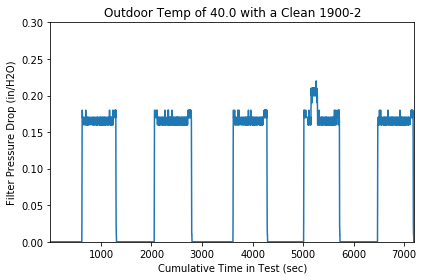

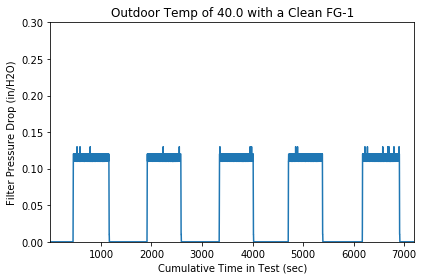

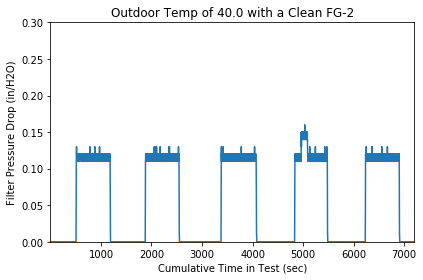

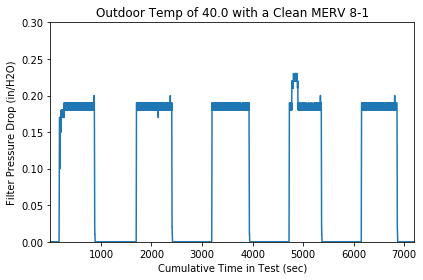

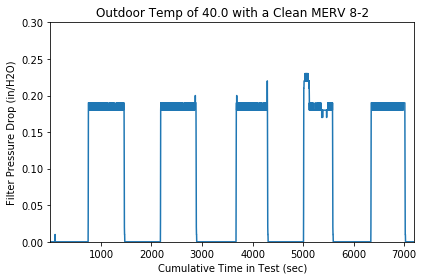

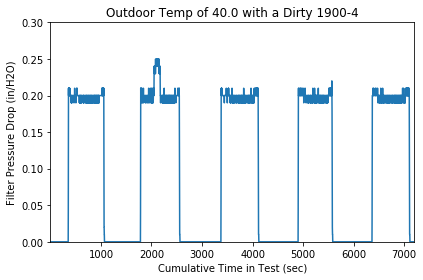

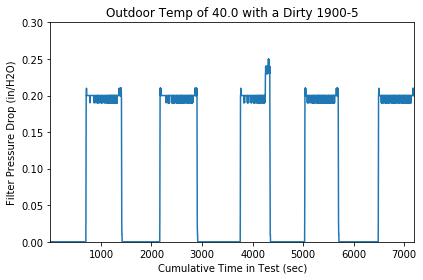

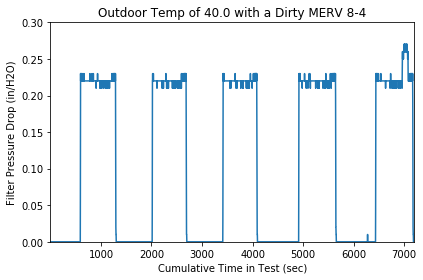

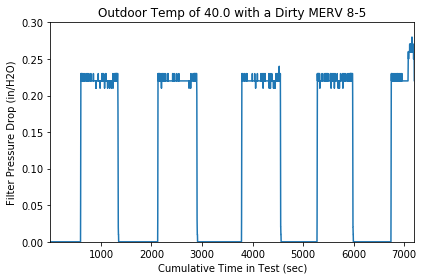

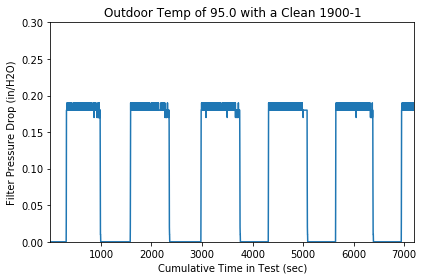

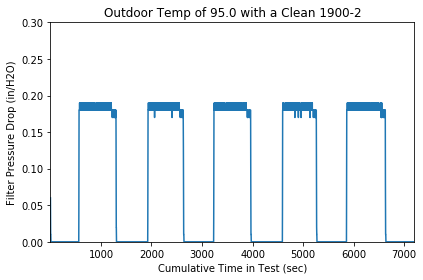

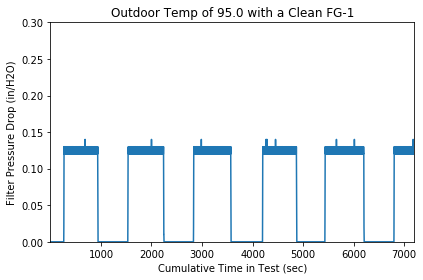

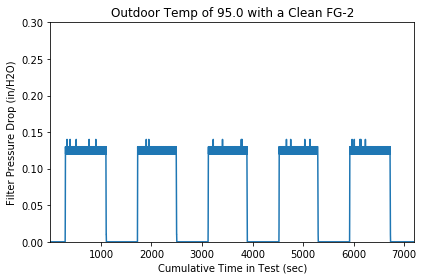

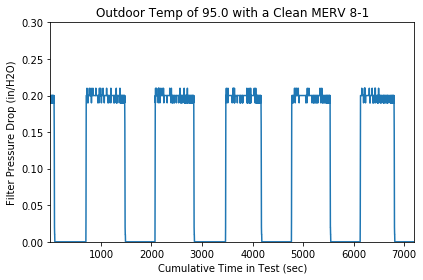

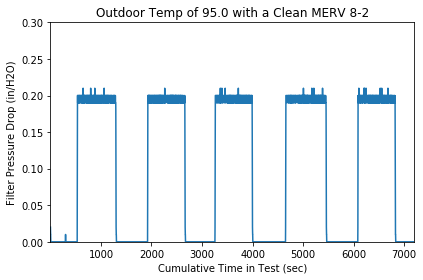

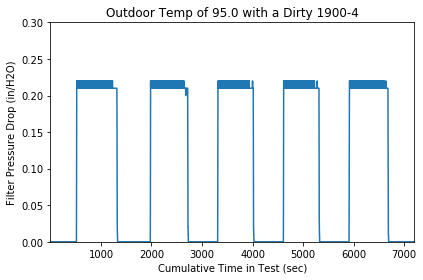

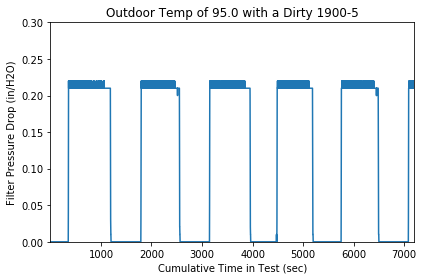

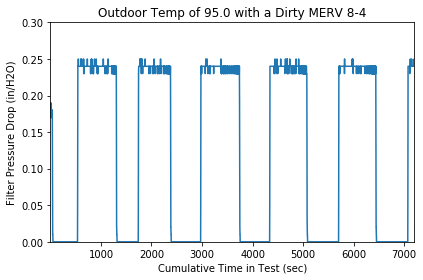

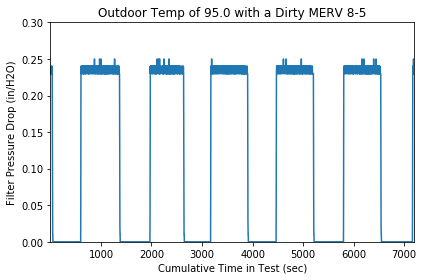

In [41]:
# Pressure Drop across the filter vs Time

FilteredData_df['Clean/Dirty Filter ID'] = FilteredData_df['Clean/Dirty'] + str(' ') + FilteredData_df['Filter ID']

Grouped2 = FilteredData_df[FilteredData_df['Cumulative Time in Test (sec)']<=second_cut_off].groupby(['Outdoor Temp', 'Clean/Dirty Filter ID'])

samplelist = ['Clean 1900-1', 'Clean 1900-2', 'Clean FG-1', 'Clean FG-2', 'Clean MERV 8-1', 'Clean MERV 8-2', 
              'Dirty 1900-4', 'Dirty 1900-5', 'Dirty MERV 8-4', 'Dirty MERV 8-5']

seasons = [40.0, 95.0]

pd_ylim = max(FilteredData_df['Filter Pressure Drop (in/H2O)'])

for season in seasons:
    for sample in samplelist:

        PD_plot = Grouped2.get_group((season, sample)).plot(kind='line', 
                                                  x='Cumulative Time in Test (sec)', 
                                                  y=['Filter Pressure Drop (in/H2O)'],
                                                  ylim=(0,pd_ylim+0.02), legend=False, 
                                                  title=str('Outdoor Temp of ') + str(season) + str(' with a ') + sample
                                                 )
        plt.savefig("Images/Pressure Drop Plots/" + str(sample) + " Pressure Drops over Time.png")
        PD_plot.set_ylabel('Filter Pressure Drop (in/H2O)')
        plt.tight_layout()

/Users/abby/miniconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


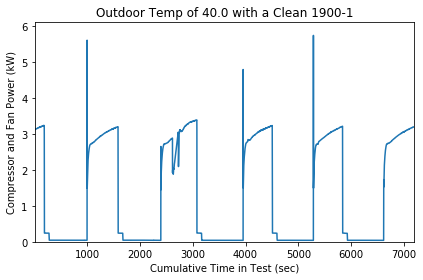

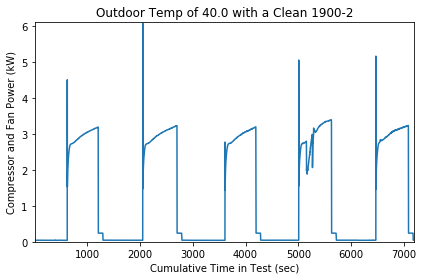

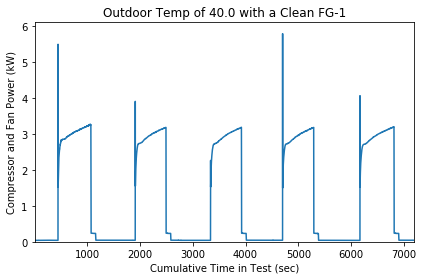

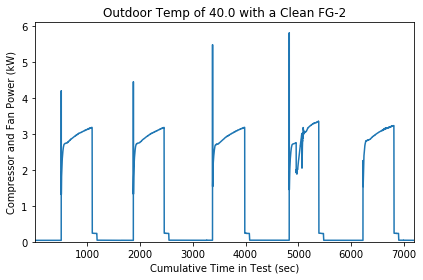

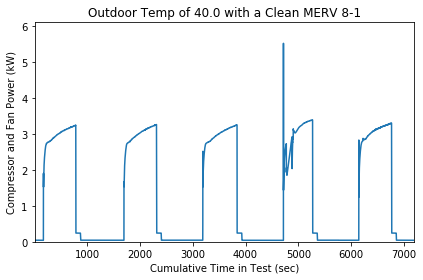

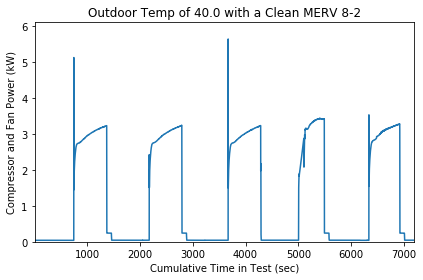

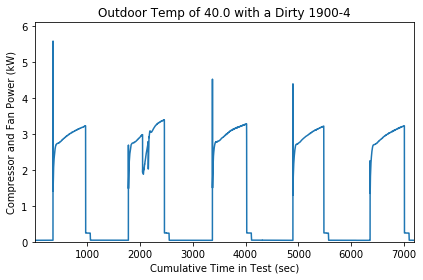

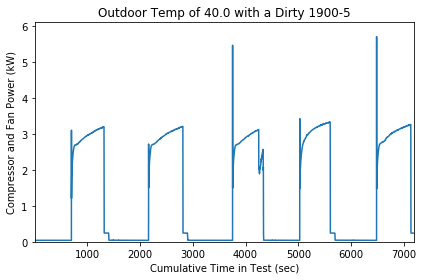

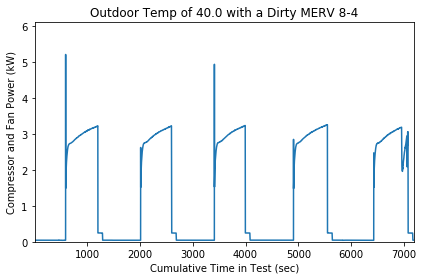

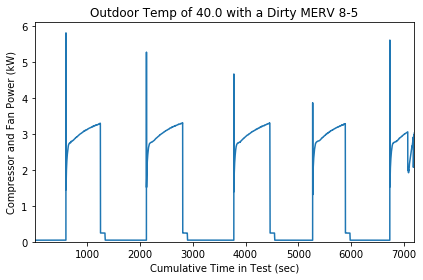

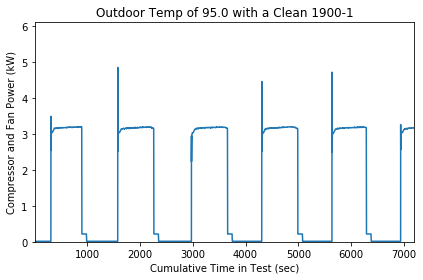

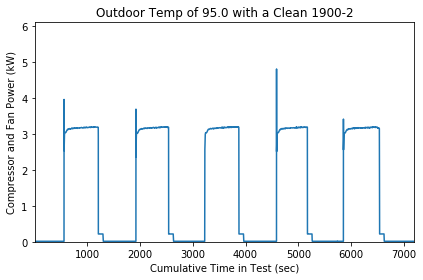

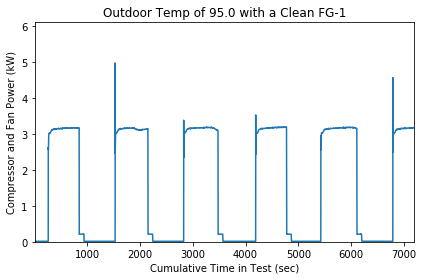

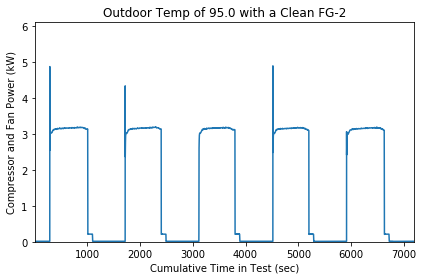

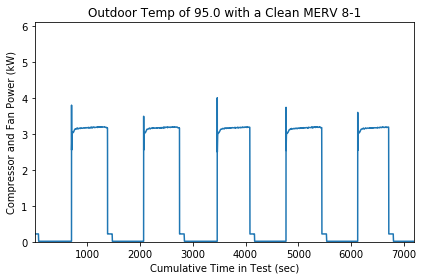

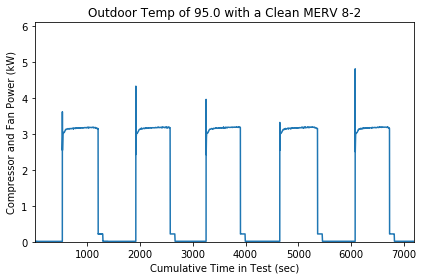

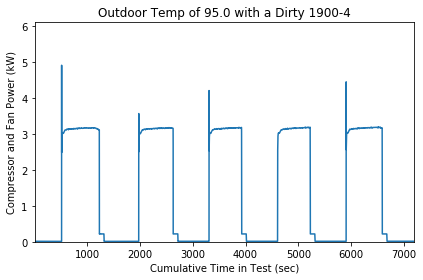

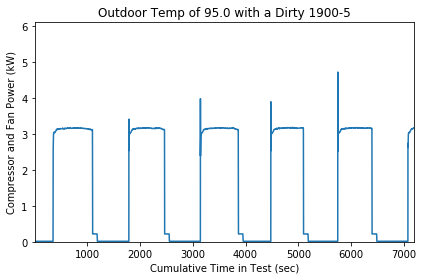

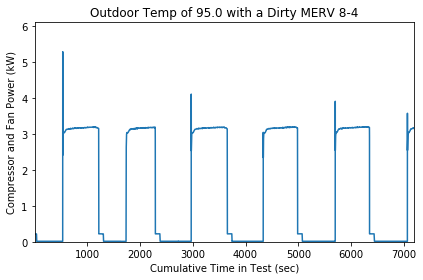

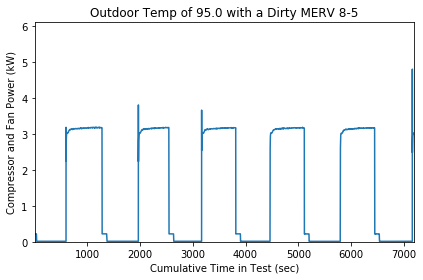

In [42]:
# HVAC Energy vs Time

FilteredData_df['Clean/Dirty Filter ID'] = FilteredData_df['Clean/Dirty'] + str(' ') + FilteredData_df['Filter ID']

Grouped1 = FilteredData_df[FilteredData_df['Cumulative Time in Test (sec)']<=second_cut_off].groupby(['Outdoor Temp', 'Clean/Dirty Filter ID'])

samplelist = ['Clean 1900-1', 'Clean 1900-2', 'Clean FG-1', 'Clean FG-2', 'Clean MERV 8-1', 'Clean MERV 8-2', 
              'Dirty 1900-4', 'Dirty 1900-5', 'Dirty MERV 8-4', 'Dirty MERV 8-5']

seasons = [40.0, 95.0]

for season in seasons:
    for sample in samplelist:

        power_plot = Grouped1.get_group((season, sample)).plot(kind='line', 
                                                  x='Cumulative Time in Test (sec)', 
                                                  y=['Compressor and Fan Power (kW)'],
                                                  ylim=(0,6.1), legend=False, 
                                                  title=str('Outdoor Temp of ') + str(season) + str(' with a ') + sample
                                                 )
        power_plot.set_ylabel('Compressor and Fan Power (kW)')
        plt.tight_layout()
        plt.savefig("Images/Energy Plots/" + str(sample) + " Power Cycling over Time.png")

# More Data Munging

In [15]:
# gather all non zero pressure drop values

pressuredrop_df = FilteredData_df[FilteredData_df['Cumulative Time in Test (sec)']<=second_cut_off]

pressuredrop_df = pressuredrop_df[pressuredrop_df['Filter Pressure Drop (in/H2O)']!=0.0]

pressuredrop_df = pressuredrop_df.drop(columns=['Volts', 'Volts.1', 'Amps', 'Amps.1', 'Volts.2', 'Volts.3', 'Amps.2', 'Amps.3'])
  
pressuredrop_df['Clean/Dirty Filter ID'] = pressuredrop_df['Clean/Dirty'] + str(' ') + pressuredrop_df['Filter ID']
    
pressuredrop_cooling_df = pressuredrop_df[pressuredrop_df['Outdoor Temp']==95.0]

pressuredrop_heating_df = pressuredrop_df[pressuredrop_df['Outdoor Temp']==40.0]

pressuredrop_heating_df
    

,Date,Time,Filter Pressure Drop (in/H2O),Date and Time,Whole Home Power (kW),Compressor Power (kW),Blower Fan Power (kW),Compressor and Fan Power (kW),Filter ID,Outdoor Temp,Clean/Dirty,Cumulative Time in Test (sec),Clean/Dirty Filter ID
165299,2019/11/25,07:29:28,0.01,2019-11-25 07:29:28,3.904250,1.55364,0.0432,1.59684,FG-1,40.0,Clean,449.0,Clean FG-1
165300,2019/11/25,07:29:29,0.04,2019-11-25 07:29:29,4.044900,1.58994,0.0900,1.67994,FG-1,40.0,Clean,450.0,Clean FG-1
165301,2019/11/25,07:29:30,0.08,2019-11-25 07:29:30,4.284975,1.63350,0.1572,1.79070,FG-1,40.0,Clean,451.0,Clean FG-1
165302,2019/11/25,07:29:31,0.11,2019-11-25 07:29:31,4.520200,1.67948,0.1968,1.87628,FG-1,40.0,Clean,452.0,Clean FG-1
165303,2019/11/25,07:29:32,0.12,2019-11-25 07:29:32,4.648725,1.72788,0.2016,1.92948,FG-1,40.0,Clean,453.0,Clean FG-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
350283,2019/11/27,10:52:55,0.20,2019-11-27 10:52:55,1.378377,0.03159,0.2100,0.24159,1900-5,40.0,Dirty,7196.0,Dirty 1900-5
350284,2019/11/27,10:52:56,0.20,2019-11-27 10:52:56,1.378377,0.03159,0.2100,0.24159,1900-5,40.0,Dirty,7197.0,Dirty 1900-5
350285,2019/11/27,10:52:57,0.20,2019-11-27 10:52:57,1.378377,0.03159,0.2100,0.24159,1900-5,40.0,Dirty,7198.0,Dirty 1900-5
350286,2019/11/27,10:52:58,0.20,2019-11-27 10:52:58,1.378377,0.03159,0.2100,0.24159,1900-5,40.0,Dirty,7199.0,Dirty 1900-5


In [45]:
#Gathering Energy consumed by using groupby()
#Group the data for only the first 2 hours the filter was tested
second_cut_off = 7200
Grouped_df = FilteredData_df[FilteredData_df['Cumulative Time in Test (sec)'] <= second_cut_off].groupby(['Outdoor Temp','Clean/Dirty','Filter ID'])

#Calculate the Energy and convert from seconds to hours  
Energy_Consumped_df = pd.DataFrame((Grouped_df['Whole Home Power (kW)'].sum())/(3600))
Energy_Consumped_df = Energy_Consumped_df.rename(columns={'Whole Home Power (kW)': 'Whole Home Energy (kWh)'})

Energy_Consumped_df['Compressor Energy (kWh)'] = (Grouped_df['Compressor Power (kW)'].sum())/(3600)

Energy_Consumped_df['Blower Fan Energy (kWh)'] = (Grouped_df['Blower Fan Power (kW)'].sum())/(3600)

Energy_Consumped_df['Compressor and Fan Energy (kWh)'] = (Grouped_df['Compressor and Fan Power (kW)'].sum())/(3600)

Energy_Consumped_df.to_excel('Data/Energy Consumption per Filter.xlsx')

Energy_Consumped_df

Whole Home Energy (kWh)  \
Outdoor Temp Clean/Dirty Filter ID                            
40.0         Clean       1900-1                    7.531882   
                         1900-2                    7.390566   
                         FG-1                      6.310025   
                         FG-2                      7.127589   
                         MERV 8-1                  7.428590   
                         MERV 8-2                  7.176912   
             Dirty       1900-4                    7.576423   
                         1900-5                    7.100304   
                         MERV 8-4                  7.313377   
                         MERV 8-5                  7.461322   
95.0         Clean       1900-1                   10.593882   
                         1900-2                    9.927605   
                         FG-1                     10.553045   
                         FG-2                     10.434825   
                         MERV 8-1                 10.058702   
                         MERV 8-2                 10.205792   
             Dirty       1900-4                   10.097331   
                         1900-5                   10.562309   
                         MERV 8-4                 10.236331   
                         MERV 8-5                 10.015249   

                                    Compressor Energy (kWh)  \
Outdoor Temp Clean/Dirty Filter ID                            
40.0         Clean       1900-1                    2.423465   
                         1900-2                    2.353606   
                         FG-1                      2.331714   
                         FG-2                      2.245040   
                         MERV 8-1                  2.385441   
                         MERV 8-2                  2.299641   
             Dirty       1900-4                    2.440349   
                         1900-5                    2.356616   
                         MERV 8-4                  2.352095   
                         MERV 8-5                  2.404128   
95.0         Clean       1900-1                    2.901969   
                         1900-2                    2.603468   
                         FG-1                      2.886659   
                         FG-2                      2.843068   
                         MERV 8-1                  2.655592   
                         MERV 8-2                  2.733263   
             Dirty       1900-4                    2.673822   
                         1900-5                    2.872249   
                         MERV 8-4                  2.733752   
                         MERV 8-5                  2.638949   

                                    Blower Fan Energy (kWh)  \
Outdoor Temp Clean/Dirty Filter ID                            
40.0         Clean       1900-1                    0.224022   
                         1900-2                    0.219081   
                         FG-1                      0.211798   
                         FG-2                      0.208121   
                         MERV 8-1                  0.219926   
                         MERV 8-2                  0.208227   
             Dirty       1900-4                    0.229086   
                         1900-5                    0.215168   
                         MERV 8-4                  0.222712   
                         MERV 8-5                  0.219419   
95.0         Clean       1900-1                    0.247556   
                         1900-2                    0.227225   
                         FG-1                      0.238480   
                         FG-2                      0.236400   
                         MERV 8-1                  0.235991   
                         MERV 8-2                  0.237958   
             Dirty       1900-4                    0.235152   
                         1900-5                    0.247742   
  

In [17]:
#create a new group with just values during the heating season
#Gathering Energy consumed by using groupby()
#Group the data for only the first 2 hours the filter was tested
second_cut_off = 7200
Heating_df = FilteredData_df[FilteredData_df['Outdoor Temp'] == 40.0]
GroupedHeating_df = Heating_df[Heating_df['Cumulative Time in Test (sec)'] <= second_cut_off].groupby(['Clean/Dirty','Filter ID'])

#Calculate the Energy and convert from seconds to hours  
Energy_Consumped_Heating_df = pd.DataFrame((GroupedHeating_df['Whole Home Power (kW)'].sum())/(3600))
Energy_Consumped_Heating_df = Energy_Consumped_Heating_df.rename(columns={'Whole Home Power (kW)': 'Whole Home Energy (kWh)'})

Energy_Consumped_Heating_df['Compressor Energy (kWh)'] = (GroupedHeating_df['Compressor Power (kW)'].sum())/(3600)

Energy_Consumped_Heating_df['Blower Fan Energy (kWh)'] = (GroupedHeating_df['Blower Fan Power (kW)'].sum())/(3600)

Energy_Consumped_Heating_df['Compressor and Fan Energy (kWh)'] = (GroupedHeating_df['Compressor and Fan Power (kW)'].sum())/(3600)

Energy_Consumped_Heating_df['Sort Column'] = [4, 5, 0, 1, 2, 3, 8, 9, 6, 7]

Energy_Consumped_Heating_df = Energy_Consumped_Heating_df.sort_values('Sort Column')

Energy_Consumped_Heating_df

Whole Home Energy (kWh)  Compressor Energy (kWh)  \
Clean/Dirty Filter ID                                                     
Clean       FG-1                      6.310025                 2.331714   
            FG-2                      7.127589                 2.245040   
            MERV 8-1                  7.428590                 2.385441   
            MERV 8-2                  7.176912                 2.299641   
            1900-1                    7.531882                 2.423465   
            1900-2                    7.390566                 2.353606   
Dirty       MERV 8-4                  7.313377                 2.352095   
            MERV 8-5                  7.461322                 2.404128   
            1900-4                    7.576423                 2.440349   
            1900-5                    7.100304                 2.356616   

                       Blower Fan Energy (kWh)  \
Clean/Dirty Filter ID                            
Clean       FG-1                      0.211798   
            FG-2                      0.208121   
            MERV 8-1                  0.219926   
            MERV 8-2                  0.208227   
            1900-1                    0.224022   
            1900-2                    0.219081   
Dirty       MERV 8-4                  0.222712   
            MERV 8-5                  0.219419   
            1900-4                    0.229086   
            1900-5                    0.215168   

                       Compressor and Fan Energy (kWh)  Sort Column  
Clean/Dirty Filter ID                                                
Clean       FG-1                              2.543512            0  
            FG-2                              2.453161            1  
            MERV 8-1                          2.605367            2  
            MERV 8-2                          2.507867            3  
            1900-1                            2.647487            4  
            1900-2                            2.572686            5  
Dirty       MERV 8-4                          2.574807            6  
            MERV 8-5                          2.623547            7  
            1900-4                            2.669436            8  
            1900-5                            2.571784            9

In [18]:
#create a new group with just values during the cooling season
#Gathering Energy consumed by using groupby()
#Group the data for only the first 2 hours the filter was tested
second_cut_off = 7200
Cooling_df = FilteredData_df[FilteredData_df['Outdoor Temp'] == 95.0]
time_cut_off_Cooling_df = Cooling_df[Cooling_df['Cumulative Time in Test (sec)'] <= second_cut_off]
GroupedCooling_df = Cooling_df[Cooling_df['Cumulative Time in Test (sec)'] <= second_cut_off].groupby(['Clean/Dirty','Filter ID'])

#Calculate the Energy and convert from seconds to hours  
Energy_Consumped_Cooling_df = pd.DataFrame((GroupedCooling_df['Whole Home Power (kW)'].sum())/(3600))
Energy_Consumped_Cooling_df = Energy_Consumped_Cooling_df.rename(columns={'Whole Home Power (kW)': 'Whole Home Energy (kWh)'})

Energy_Consumped_Cooling_df['Compressor Energy (kWh)'] = (GroupedCooling_df['Compressor Power (kW)'].sum())/(3600)

Energy_Consumped_Cooling_df['Blower Fan Energy (kWh)'] = (GroupedCooling_df['Blower Fan Power (kW)'].sum())/(3600)

Energy_Consumped_Cooling_df['Compressor and Fan Energy (kWh)'] = (GroupedCooling_df['Compressor and Fan Power (kW)'].sum())/(3600)

Energy_Consumped_Cooling_df['Sort Column'] = [4, 5, 0, 1, 2, 3, 8, 9, 6, 7]

Energy_Consumped_Cooling_df = Energy_Consumped_Cooling_df.sort_values('Sort Column')

Energy_Consumped_Cooling_df

Whole Home Energy (kWh)  Compressor Energy (kWh)  \
Clean/Dirty Filter ID                                                     
Clean       FG-1                     10.553045                 2.886659   
            FG-2                     10.434825                 2.843068   
            MERV 8-1                 10.058702                 2.655592   
            MERV 8-2                 10.205792                 2.733263   
            1900-1                   10.593882                 2.901969   
            1900-2                    9.927605                 2.603468   
Dirty       MERV 8-4                 10.236331                 2.733752   
            MERV 8-5                 10.015249                 2.638949   
            1900-4                   10.097331                 2.673822   
            1900-5                   10.562309                 2.872249   

                       Blower Fan Energy (kWh)  \
Clean/Dirty Filter ID                            
Clean       FG-1                      0.238480   
            FG-2                      0.236400   
            MERV 8-1                  0.235991   
            MERV 8-2                  0.237958   
            1900-1                    0.247556   
            1900-2                    0.227225   
Dirty       MERV 8-4                  0.242893   
            MERV 8-5                  0.236574   
            1900-4                    0.235152   
            1900-5                    0.247742   

                       Compressor and Fan Energy (kWh)  Sort Column  
Clean/Dirty Filter ID                                                
Clean       FG-1                              3.125139            0  
            FG-2                              3.079467            1  
            MERV 8-1                          2.891583            2  
            MERV 8-2                          2.971221            3  
            1900-1                            3.149524            4  
            1900-2                            2.830693            5  
Dirty       MERV 8-4                          2.976645            6  
            MERV 8-5                          2.875522            7  
            1900-4                            2.908973            8  
            1900-5                            3.119991            9

# Ploting Grouped Results

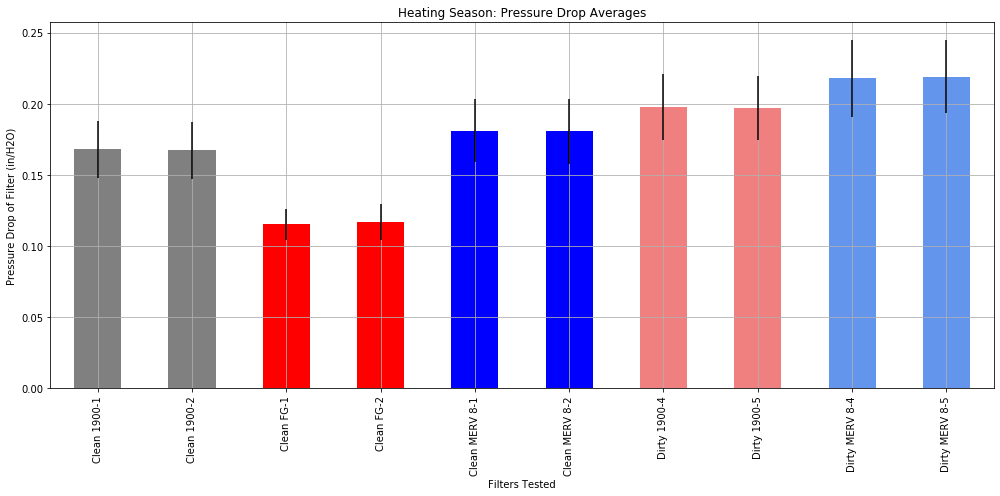

In [28]:
#graph pressure drop across filter results from the heating season
pressuredrop_heating_df

pressuredrop_heating_group = pressuredrop_heating_df.groupby(['Clean/Dirty Filter ID'])

pressuredrop_heating_group_df = pressuredrop_heating_group.mean()

pd_heating_group_err_df = pressuredrop_heating_group['Filter Pressure Drop (in/H2O)'].std()

error = list(pd_heating_group_err_df)

heat_PD_plot = pressuredrop_heating_group_df['Filter Pressure Drop (in/H2O)'].plot(kind='bar',
                                                                    color=['grey', 'grey', 'r', 'r', 'b', 'b', 'lightcoral', 'lightcoral', 'cornflowerblue', 'cornflowerblue'],
                                                                    figsize = (14,7),
                                                                    yerr=error
                                                                   )

plt.xlabel('Filters Tested')
plt.title('Heating Season: Pressure Drop Averages')
heat_PD_plot.set_ylabel('Pressure Drop of Filter (in/H2O)')
plt.grid(True)
plt.tight_layout()
plt.savefig('Images/Pressure Drop Plots/HeatingSeason_Pressure_Drop.png')

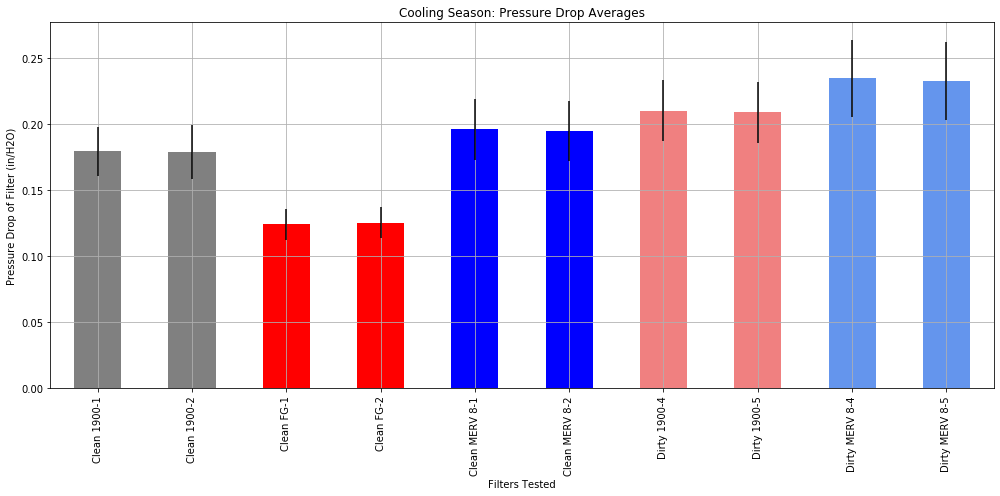

In [29]:
#graph pressure drop across filter results from the cooling season
pressuredrop_cooling_df

pressuredrop_cooling_group = pressuredrop_cooling_df.groupby(['Clean/Dirty Filter ID'])

pressuredrop_cooling_group_df = pressuredrop_cooling_group.mean()

pd_cooling_group_err_df = pressuredrop_cooling_group['Filter Pressure Drop (in/H2O)'].std()

error = list(pd_cooling_group_err_df)

pressuredrop_cooling_group_df

cool_PD_plot = pressuredrop_cooling_group_df['Filter Pressure Drop (in/H2O)'].plot(kind='bar',
                                                                    color=['grey', 'grey', 'r', 'r', 'b', 'b', 'lightcoral', 'lightcoral', 'cornflowerblue', 'cornflowerblue'],
                                                                    yerr=error,
                                                                    figsize = (14,7)
                                                                   )

plt.xlabel('Filters Tested')
plt.title('Cooling Season: Pressure Drop Averages')
cool_PD_plot.set_ylabel('Pressure Drop of Filter (in/H2O)')
plt.grid(True)
plt.tight_layout()
plt.savefig('Images/Pressure Drop Plots/CoolingSeason_Pressure_Drop.png')

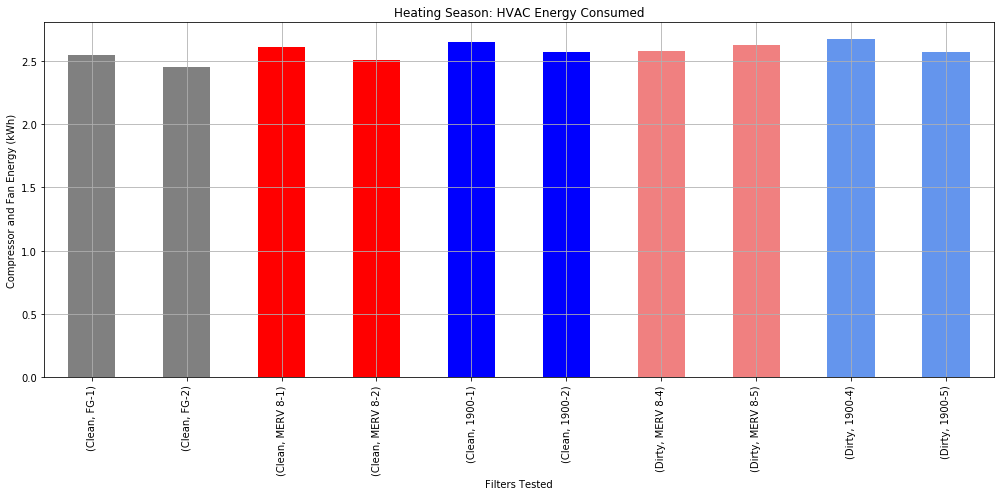

In [37]:
#graph Energy_Consumped_Heating_df results

heat_HVACenergy_plot = Energy_Consumped_Heating_df['Compressor and Fan Energy (kWh)'].plot(kind='bar', 
                                                                    color=['grey', 'grey', 'r', 'r', 'b', 'b', 'lightcoral', 'lightcoral', 'cornflowerblue', 'cornflowerblue'],
                                                                    figsize = (14,7)
                                                                   )
plt.xlabel('Filters Tested')
plt.title('Heating Season: HVAC Energy Consumed')
heat_HVACenergy_plot.set_ylabel('Compressor and Fan Energy (kWh)')
plt.grid(True)
plt.tight_layout()
plt.savefig('Images/Energy Plots/Heating_Season_HVAC_Energy')

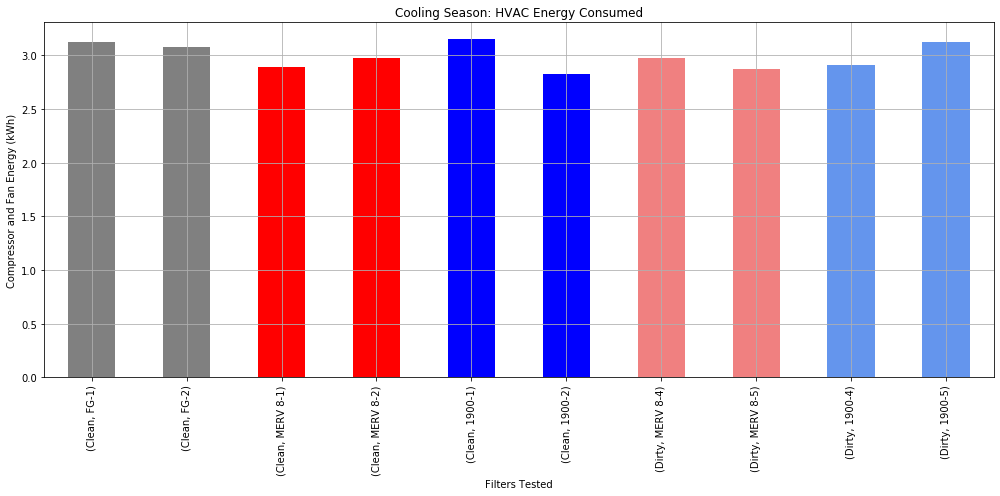

In [33]:
#graph Energy_Consumped_Cooling_df results for HVAC unit

cool_HVACenergy_plot = Energy_Consumped_Cooling_df['Compressor and Fan Energy (kWh)'].plot(kind='bar', 
                                                                    color=['grey', 'grey', 'r', 'r', 'b', 'b', 'lightcoral', 'lightcoral', 'cornflowerblue', 'cornflowerblue'],
                                                                    figsize=(14,7)
                                                                   )

cool_HVACenergy_plot.set_ylabel('Compressor and Fan Energy (kWh)')
plt.xlabel('Filters Tested')
plt.title('Cooling Season: HVAC Energy Consumed')
plt.grid(True)
plt.tight_layout()
plt.savefig('Images/Energy Plots/Cooling_Season_HVAC_Energy.png')

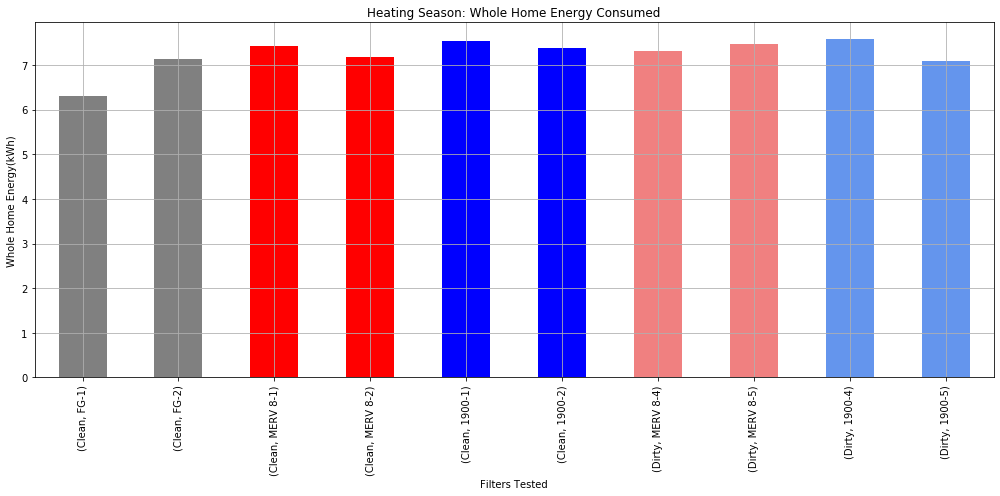

In [34]:
#graph Energy_Consumped_Heating_df results for Whole Home

heat_HomeEnergy_plot = Energy_Consumped_Heating_df['Whole Home Energy (kWh)'].plot(kind='bar', 
                                                            color=['grey', 'grey', 'r', 'r', 'b', 'b', 'lightcoral', 'lightcoral', 'cornflowerblue', 'cornflowerblue'],
                                                            figsize=(14,7)
                                                                   )
plt.xlabel('Filters Tested')
plt.title('Heating Season: Whole Home Energy Consumed')
heat_HomeEnergy_plot.set_ylabel('Whole Home Energy(kWh)')
plt.grid(True)
plt.tight_layout()
plt.savefig('Images/Energy Plots/Heating_Season_WholeHome_Energy')

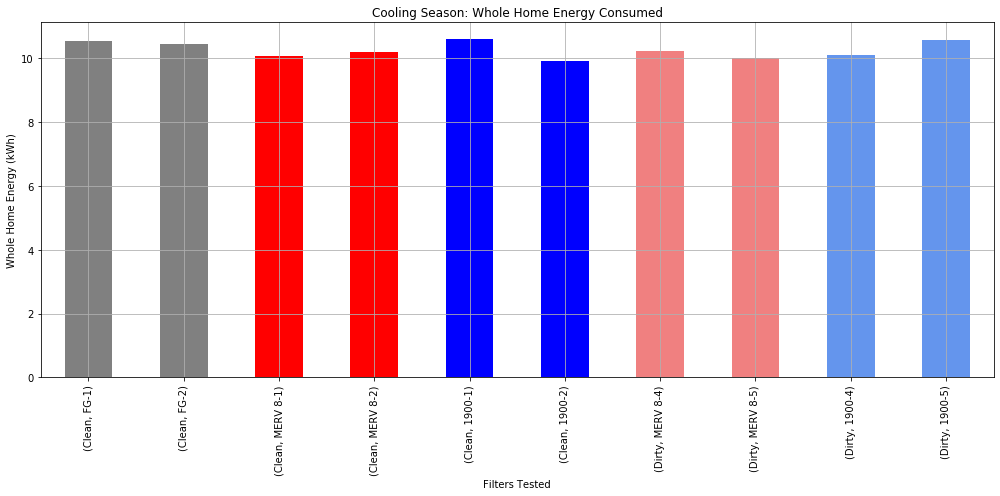

In [35]:
#graph Energy_Consumped_Cooling_df results for Whole Home

cool_HomeEnergy_plot = Energy_Consumped_Cooling_df['Whole Home Energy (kWh)'].plot(kind='bar',
                                                            y='Whole Home Energy (kWh)',
                                                            color=['grey', 'grey', 'r', 'r', 'b', 'b', 'lightcoral', 'lightcoral', 'cornflowerblue', 'cornflowerblue'], 
                                                            figsize=(14,7)
                                                                   )
plt.xlabel('Filters Tested')
plt.title('Cooling Season: Whole Home Energy Consumed')
cool_HomeEnergy_plot.set_ylabel('Whole Home Energy (kWh)')
plt.grid(True)
plt.tight_layout()
plt.savefig('Images/Energy Plots/Cooling_Season_WholeHome_Energy')

In [ ]:
# plot of Energy vs time for all samples (20 scatter) -- Done
# pressure drop vs time for clean filters in a season (20 scatter) -- Done
# average pressure drop for heating and another for cooling (2 bar + time based error bars) -- Done
# compressor and fan energy (kWh) for heating and cooling (2 bar + time based error bars) -- error bars?
# whole home energy (kWh) for heating and cooling (2 bar + time based error bars) -- error bars?

In [ ]:
# .png cut off some of the graph axis. --> plt.tightlayout() fixed that problem